In [1]:
import numpy as np
import librosa
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch.utils.data import random_split, Dataset, DataLoader


Filter data to just include canonical and non canonical for now

In [2]:
audios = pd.read_csv("/content/drive/MyDrive/SPOG/Audio_Clips_Balanced.csv")

In [3]:
audios = audios[audios["Answer"] != "Other"]

Get the mel spectrogram

In [4]:
def get_melspectrogram_db(file_path, sr=None, n_fft=1600, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav, sr = librosa.load(file_path, sr=sr)
  if wav.shape[0]<.5*sr:
    wav = np.concatenate([wav, wav[-1].repeat(int(0.5 * sr) - wav.shape[0])])

  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)

  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [5]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [6]:
from torchvision.models import resnet34
import torch
import torch.nn as nn
import torch.optim as optim
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,1)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 65.1MB/s]


In [7]:
prefix = '/content/drive/MyDrive/SPOG/BabbleCor_clips/'

class AudioArrays(Dataset):
    def __init__(self, base, df, in_col, out_col, frames_per_second=128, max_duration=0.5):
      self.df = df
      self.data = []
      self.labels = []
      self.frames_per_second = frames_per_second
      self.max_frames = int(frames_per_second * max_duration)

      self.label_mapping = {'Canonical': 0, 'Non-canonical': 1}

      for ind in tqdm(range(len(df))):
        row = df.iloc[ind]
        file_path = os.path.join(base, row[in_col])
        spec = spec_to_image(get_melspectrogram_db(file_path))[np.newaxis, ...]

        # Pad or truncate the spectrogram to the target number of frames
        if spec.shape[2] < self.max_frames:
            leftover = self.max_frames - spec.shape[2]
            half = leftover // 2

            if leftover % 2 == 0:
                spec = np.pad(spec, ((0, 0), (0, 0), (half, half)), mode='reflect')
            else:
                spec = np.pad(spec, ((0, 0), (0, 0), (half + 1, half)), mode='reflect')

        label = self.label_mapping[row[out_col]]
        self.data.append(spec)
        self.labels.append(np.float32(label))

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      return self.data[idx], torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)

#setting random seed for entire environment
seed = 42
torch.manual_seed(seed)

train_size = int(0.8 * len(audios))
valid_size = len(audios) - train_size
train, valid = random_split(audios, [train_size, valid_size])

audios_dataset = AudioArrays(prefix, audios, 'clip_ID', 'Answer', frames_per_second=128, max_duration=0.5)

train_dataset, valid_dataset = random_split(audios_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, worker_init_fn=torch.manual_seed(seed))
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, worker_init_fn=torch.manual_seed(seed))

100%|██████████| 3652/3652 [20:36<00:00,  2.95it/s]


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch - 0 Train-Loss : 0.0007907364128375457
Epoch - 0 Valid-Loss : 1.7893981282477793 Valid-Accuracy : 0.6744186046511628


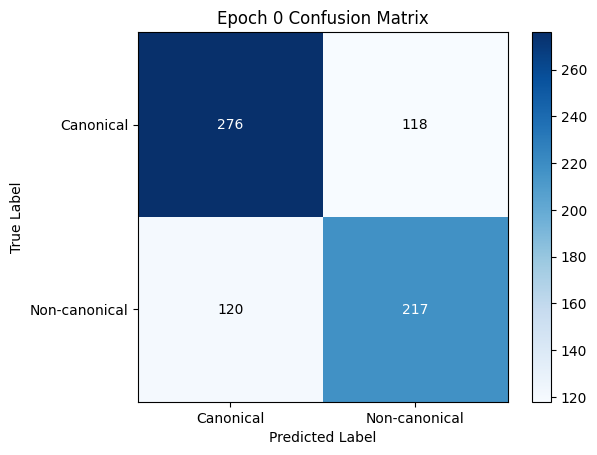

  8%|▊         | 1/12 [03:28<38:16, 208.81s/it]

Epoch - 1 Train-Loss : 0.0012349128809039597
Epoch - 1 Valid-Loss : 1.7823990648207457 Valid-Accuracy : 0.6757865937072504


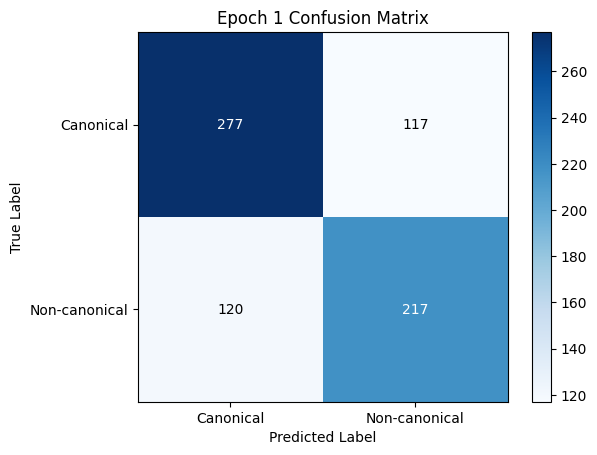

 17%|█▋        | 2/12 [06:52<34:20, 206.07s/it]

Changed learning rate to 3e-08
Epoch - 2 Train-Loss : 0.0015108838336375617
Epoch - 2 Valid-Loss : 1.797213735949734 Valid-Accuracy : 0.6730506155950753


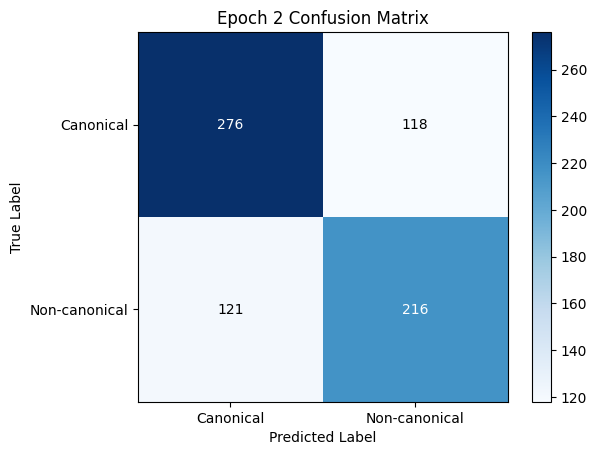

 25%|██▌       | 3/12 [10:10<30:21, 202.36s/it]

Epoch - 3 Train-Loss : 0.000975604316433712
Epoch - 3 Valid-Loss : 1.8456076811189237 Valid-Accuracy : 0.6689466484268126


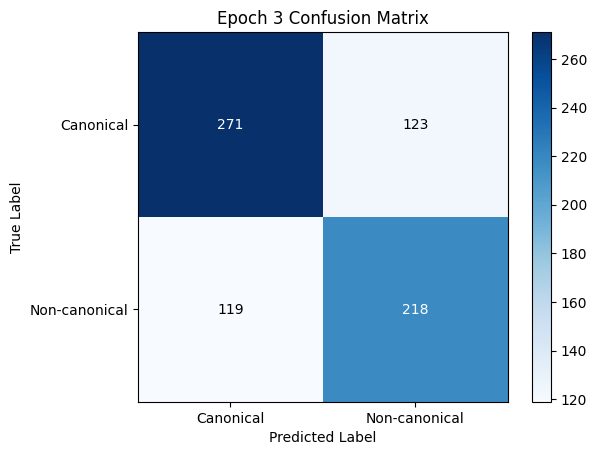

 33%|███▎      | 4/12 [13:25<26:35, 199.44s/it]

Changed learning rate to 3e-08
Epoch - 4 Train-Loss : 0.0010287694564988775
Epoch - 4 Valid-Loss : 1.8773259848518216 Valid-Accuracy : 0.6703146374829001


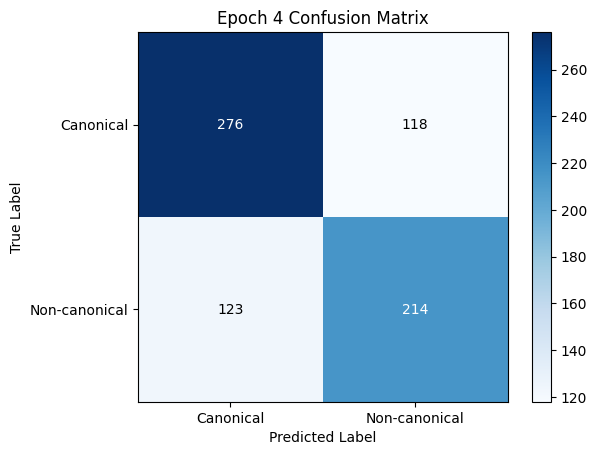

 42%|████▏     | 5/12 [16:41<23:05, 197.91s/it]

Epoch - 5 Train-Loss : 0.0017380622974365915
Epoch - 5 Valid-Loss : 1.6550481798856154 Valid-Accuracy : 0.6757865937072504


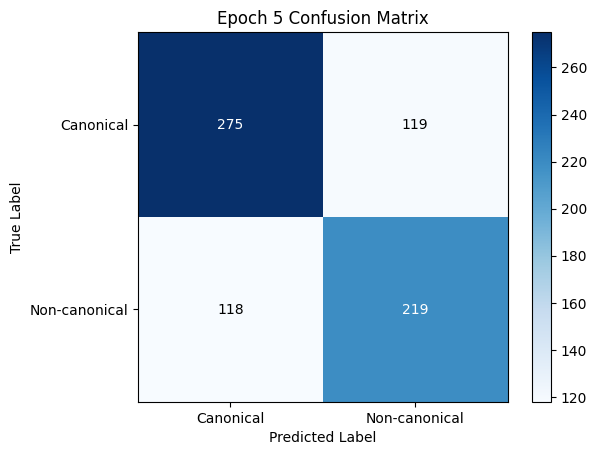

 50%|█████     | 6/12 [19:55<19:39, 196.65s/it]

Changed learning rate to 3e-08


 50%|█████     | 6/12 [21:28<21:28, 214.77s/it]


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# learning_rate = 2e-4
# learning_rate = 3e-8
learning_rate = .0001
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 12
#this loss function applies the sigmoid inside of it, so no need to apply a sigmoid layer before calculating loss
loss_fn = nn.BCEWithLogitsLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
# def lr_decay(optimizer, epoch):
#   if epoch%2==0 and epoch != 0:
#     new_lr = learning_rate / (10**(epoch//10))
#     for param_group in optimizer.param_groups:
#       param_group['lr'] = new_lr
#     print(f'Changed learning rate to {new_lr}')
#   return optimizer

def lr_exponential_decay(optimizer, epoch, initial_lr=0.001, decay_rate=0.1, decay_steps=10):
    new_lr = initial_lr * (decay_rate ** (epoch // decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    print(f'Changed learning rate to {new_lr}')
    return optimizer


def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  all_trace_y = []  # Accumulate ground truth values
  all_trace_yhat = []  # Accumulate predicted values

  for epoch in tqdm(range(0, epochs)):
    model.train()
    batch_losses = []
    if change_lr:
        optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
        x, y = data
        optimizer.zero_grad()
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        y_hat = model(x)
        # print(f'y_hat shape: {y_hat.shape}')
        # print(f'y_hat: {y_hat}')
        # print(f'y shape: {y.shape}')
        # print(f'y: {y}')
        loss = loss_fn(y_hat, y)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')

    # Validation phase
    model.eval()
    batch_losses = []
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
        x, y = data
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        y_hat = (y_hat > 0).float()
        # print(f'y_hat: {y_hat}')
        # print(f'y: {y}')
        trace_y.append(y.cpu().detach().numpy())
        trace_yhat.append(y_hat.cpu().detach().numpy())

        batch_losses.append(loss.item())

    valid_losses.append(batch_losses)
    # print(trace_y)
    # print(trace_yhat)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat == trace_y)

    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

    cm = confusion_matrix(trace_y, trace_yhat)
    plot_confusion_matrix(cm, classes=[0, 1], title=f'Epoch {epoch} Confusion Matrix')

    # Accumulate for confusion matrix
    all_trace_y.append(trace_y)
    all_trace_yhat.append(trace_yhat)

    #Save checkpoint
    # checkpoint = {
    #     'epoch': epoch,
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'train_losses': train_losses,
    #     'valid_losses': valid_losses,
    #     'valid-accuracy': accuracy,
    # }
    # torch.save(checkpoint, '/content/drive/MyDrive/SPOG/Checkpoints')

  # Calculate confusion matrix using all accumulated values
  all_trace_y = np.concatenate(all_trace_y)
  all_trace_yhat = np.concatenate(all_trace_yhat)
  cm = confusion_matrix(all_trace_y, all_trace_yhat)
  plot_confusion_matrix(cm, classes=[0, 1], title='Confusion Matrix')

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    label_mapping = {0: 'Canonical', 1: 'Non-canonical'}
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [f"{label_mapping[cls]}" for cls in classes])
    plt.yticks(tick_marks, [f"{label_mapping[cls]}" for cls in classes])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.show()

# Call the train function with your model and data loaders
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)
